In [72]:
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


In [12]:
with open('data/data.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [13]:
train_path = config['train']
val_path = config['val']
test_path = config['test']
num_classes = config['nc']
class_names = config['names']

In [14]:
print("Train Path:", train_path)
print("Validation Path:", val_path)
print("Test Path:", test_path)
print("Number of Classes:", num_classes)
print("Class Names:", class_names)

Train Path: data/train/images
Validation Path: data/valid/images
Test Path: data/test/images
Number of Classes: 25
Class Names: ['Bed', 'Cabinet', 'Carpet', 'Ceramic floor', 'Chair', 'Closet', 'Cupboard', 'Curtains', 'Dining Table', 'Door', 'Frame', 'Futec frame', 'Futech tiles', 'Gypsum Board', 'Lamp', 'Nightstand', 'Shelf', 'Sideboard', 'Sofa', 'TV stand', 'Table', 'Transparent Closet', 'Wall Panel', 'Window', 'Wooden floor']


In [15]:
def load_and_display_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

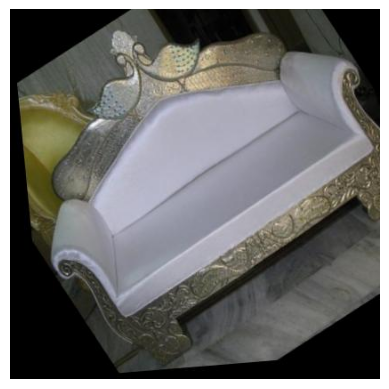

In [16]:
sample_image_path = os.path.join(train_path, os.listdir(train_path)[0])
load_and_display_image(sample_image_path)

In [18]:
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  
    image = image / 255.0 
    return image

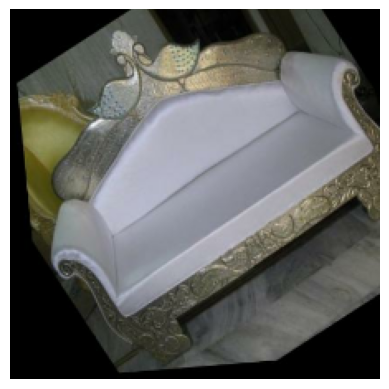

In [19]:
preprocessed_image = preprocess_image(sample_image_path)
plt.imshow(preprocessed_image)
plt.axis('off')
plt.show()

### Gather Dataset

In [35]:
def load_and_preprocess_data(image_path):
    # Convert tensor to string if needed
    image_path = image_path.numpy().decode('utf-8') if isinstance(image_path, tf.Tensor) else image_path
    
    # Load and preprocess image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0
    
    # Get corresponding label file path
    label_path = image_path.replace('images', 'labels').replace('.jpg', '.txt')
    if '.png' in image_path:
        label_path = label_path.replace('.png', '.txt')
    
    # Read label file
    try:
        with open(label_path, 'r') as f:
            # Assuming the first number in the label file is the class index
            label = int(f.readline().split()[0])
    except:
        # Handle missing label files by using a default class
        label = 0
    
    # Ensure proper shapes
    image = tf.ensure_shape(image, [224, 224, 3])
    label = tf.cast(label, tf.int32)
    return image, label

def create_dataset(image_dir, batch_size=32):
    # Get all image paths
    image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) 
                  if fname.endswith(('.jpg', '.png'))]
    
    # Create dataset from paths
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(
        lambda x: tf.py_function(
            load_and_preprocess_data, 
            [x], 
            [tf.float32, tf.int32]
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.map(
        lambda x, y: (
            tf.ensure_shape(x, [224, 224, 3]),
            tf.ensure_shape(y, [])
        )
    )
    
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [36]:
train_dataset = create_dataset(train_path)
val_dataset = create_dataset(val_path)

### Simple Model

In [49]:
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [ ]:


# Model 3
# model = models.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.25),
#     layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.25),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     layers.Dropout(0.5),
#     layers.Dense(num_classes, activation='softmax')
# ])

# Model 4
# model = models.Sequential([
#     layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(num_classes, activation='softmax')
# ])

# Model 5

# data_augmentation = tf.keras.Sequential([
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.1),
#     layers.RandomZoom(0.1),
# ])

# # 2. Create a more robust model with regularization
# model = models.Sequential([
#     # Data augmentation
#     data_augmentation,
    
#     # First Conv block
#     layers.Conv2D(64, (3, 3), padding='same', input_shape=(224, 224, 3)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.25),
    
#     # Second Conv block
#     layers.Conv2D(128, (3, 3), padding='same'),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.25),
    
#     # Third Conv block
#     layers.Conv2D(256, (3, 3), padding='same'),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.25),
    
#     # Dense layers
#     layers.Flatten(),
#     layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Dropout(0.5),
#     layers.Dense(num_classes, activation='softmax')
# ])


In [59]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# 2. Create a more robust model with regularization
model = models.Sequential([
    # Data augmentation
    data_augmentation,
    
    # First Conv block
    layers.Conv2D(64, (3, 3), padding='same', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Second Conv block
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Third Conv block
    layers.Conv2D(256, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Dense layers
    layers.Flatten(),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [63]:

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# model.summary()



In [64]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)


Epoch 1/10
201/201 [==============================] - 221s 1s/step - loss: 2.5271 - accuracy: 0.3098 - val_loss: 2.4861 - val_accuracy: 0.3075
Epoch 2/10
201/201 [==============================] - 219s 1s/step - loss: 2.1906 - accuracy: 0.3647 - val_loss: 2.2300 - val_accuracy: 0.2817
Epoch 3/10
201/201 [==============================] - 214s 1s/step - loss: 2.0474 - accuracy: 0.4058 - val_loss: 1.8592 - val_accuracy: 0.4658
Epoch 4/10
201/201 [==============================] - 210s 1s/step - loss: 1.9328 - accuracy: 0.4256 - val_loss: 3.0607 - val_accuracy: 0.3098
Epoch 5/10
201/201 [==============================] - 210s 1s/step - loss: 1.8512 - accuracy: 0.4505 - val_loss: 2.6278 - val_accuracy: 0.2694
Epoch 6/10
201/201 [==============================] - 211s 1s/step - loss: 1.7605 - accuracy: 0.4752 - val_loss: 1.6886 - val_accuracy: 0.5275
Epoch 7/10
201/201 [==============================] - 210s 1s/step - loss: 1.6990 - accuracy: 0.4899 - val_loss: 2.1026 - val_accuracy: 0.4332

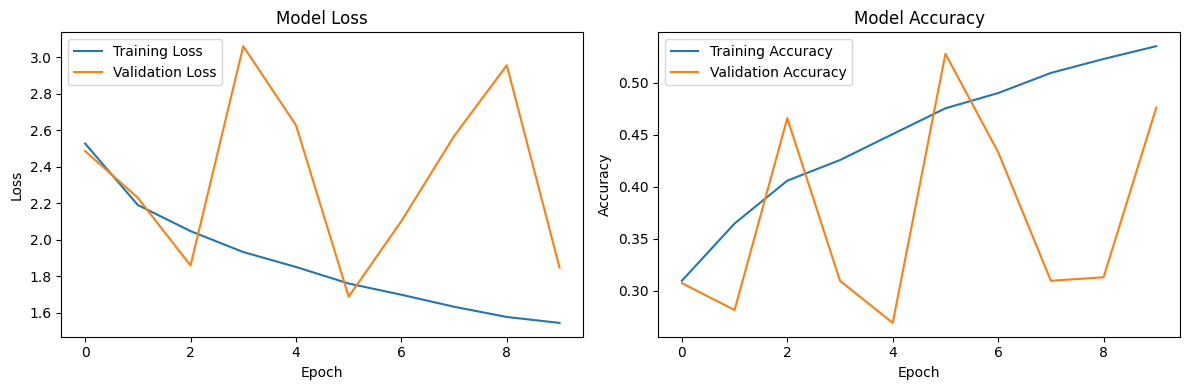

In [65]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [66]:
history = model.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20
201/201 [==============================] - 209s 1s/step - loss: 1.5128 - accuracy: 0.5384 - val_loss: 2.9773 - val_accuracy: 0.3468
Epoch 2/20
201/201 [==============================] - 211s 1s/step - loss: 1.4416 - accuracy: 0.5551 - val_loss: 2.2528 - val_accuracy: 0.3591
Epoch 3/20
201/201 [==============================] - 210s 1s/step - loss: 1.4076 - accuracy: 0.5733 - val_loss: 1.8010 - val_accuracy: 0.4882
Epoch 4/20
201/201 [==============================] - 210s 1s/step - loss: 1.3805 - accuracy: 0.5771 - val_loss: 2.7256 - val_accuracy: 0.3221
Epoch 5/20
201/201 [==============================] - 210s 1s/step - loss: 1.3279 - accuracy: 0.5957 - val_loss: 2.1815 - val_accuracy: 0.3636
Epoch 6/20
201/201 [==============================] - 210s 1s/step - loss: 1.2820 - accuracy: 0.6077 - val_loss: 1.8374 - val_accuracy: 0.4916
Epoch 7/20
201/201 [==============================] - 210s 1s/step - loss: 1.2576 - accuracy: 0.6133 - val_loss: 1.4032 - val_accuracy: 0.5791

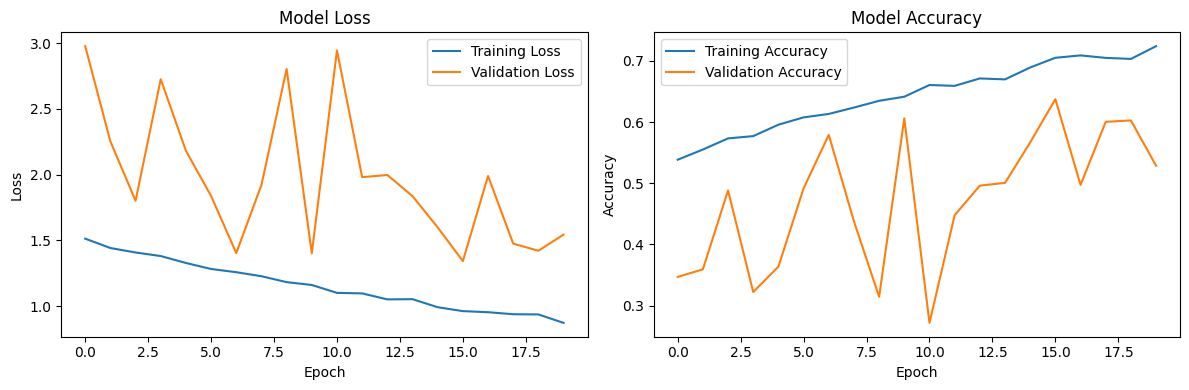

In [67]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [79]:

loss, accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

28/28 [==============================] - 9s 293ms/step - loss: 1.5437 - accuracy: 0.5286
Validation Accuracy: 52.86%


In [70]:
test_dataset = create_dataset(test_path)

loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

24/24 [==============================] - 7s 293ms/step - loss: 1.2942 - accuracy: 0.5995
Test Accuracy: 59.95%


In [76]:
y_true = []
y_pred = []

for images, labels in val_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))


1/1 [==============================] - 0s 280ms/step


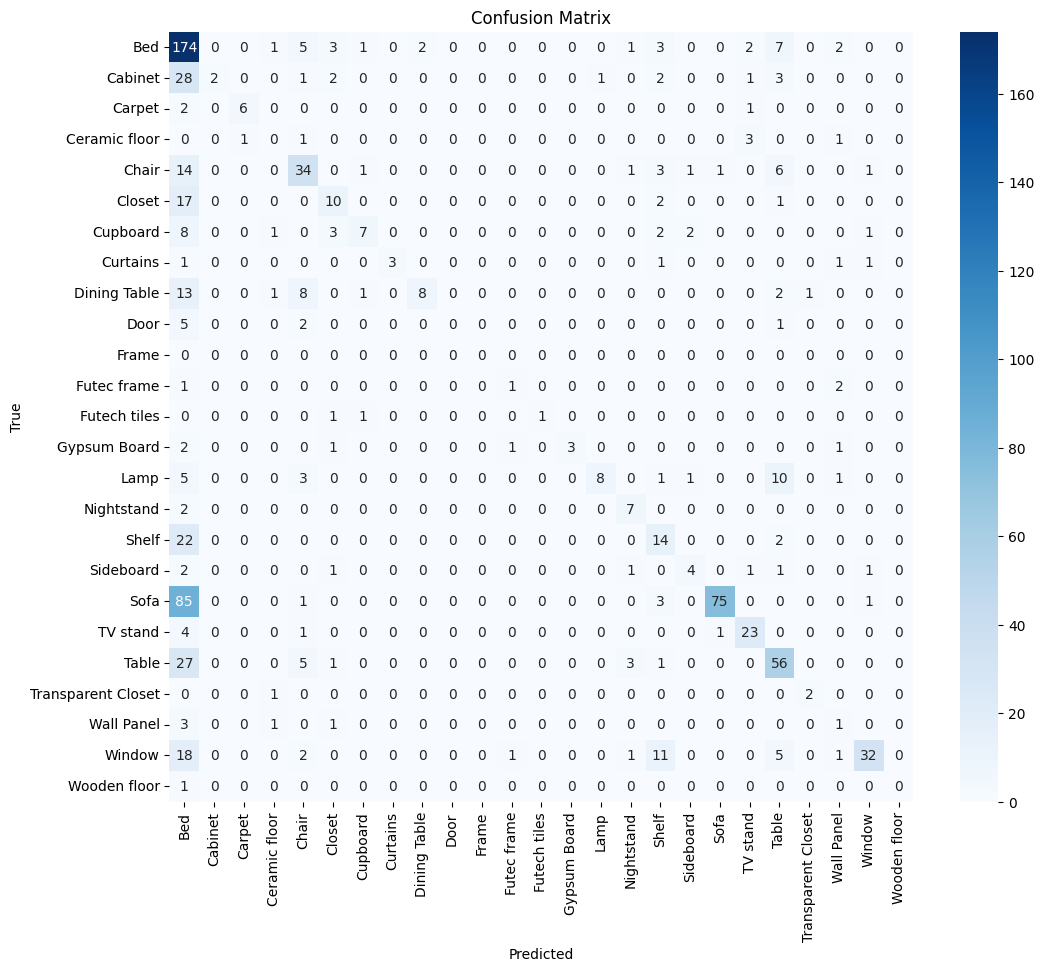

                    precision    recall  f1-score   support

               Bed       0.40      0.87      0.55       201
           Cabinet       1.00      0.05      0.10        40
            Carpet       0.86      0.67      0.75         9
     Ceramic floor       0.00      0.00      0.00         6
             Chair       0.54      0.55      0.54        62
            Closet       0.43      0.33      0.38        30
          Cupboard       0.64      0.29      0.40        24
          Curtains       1.00      0.43      0.60         7
      Dining Table       0.80      0.24      0.36        34
              Door       0.00      0.00      0.00         8
             Frame       0.00      0.00      0.00         0
       Futec frame       0.33      0.25      0.29         4
      Futech tiles       1.00      0.33      0.50         3
      Gypsum Board       1.00      0.38      0.55         8
              Lamp       0.89      0.28      0.42        29
        Nightstand       0.50      0.78

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-package

In [78]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names, labels=range(num_classes)))

#### Training Results
| Model | Epochs | Comments | Train Accuracy | Validation Accuracy |  
|-------|--------|----------|----------------|---------------------|
|   1   | 10     | Initial  |  99.00%        | 42.00%              |
|   2   | 10     | Dropout  |  33.00%        | 33.00%              |
|   3   | 20     | Dropout  |  33.00%        | 36.00%              |
|   4   | 10     | Dropout  |  99.00%        | 40.00%              |
|   5   | 20     | Dropout  |  33.00%        | 36.00%              |
|   6   | 10     | Dropout  |  53.00%        | 47.00%              |
|   7   | 20     | Dropout  |  72.00%        | 52.00%              |

Model 7 on test set: 59.95%

In [81]:
# Save model
model.save('saved_models/brian_60_accuracy.h5')